# Deep Neural Network for Image Classification: Cat pics.

In this notebook, you will implement all the functions required to build a 2-layer neural network and an L-layer deep neural network for image classification; then we will compare their respective performances


**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).



## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- dnn_utils provides some necessary functions for this notebook.
- testCases provides some test cases to assess the correctness of your functions
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work. Please don't change the seed. 

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Outline of the notebook

To build the neural networks, I will be implementing several "helper functions". These helper functions will be ease the in modeling of the two-layer neural network and an L-layer neural network.

Helper functions:

- Initialize the parameters for a two-layer network and for an $L$-layer neural network.
- Implement the forward propagation module (shown in purple in the figure below).
     - Complete the LINEAR part of a layer's forward propagation step (resulting in $Z^{[l]}$) using the ACTIVATION function (relu/sigmoid).
     - Combine the previous two steps into a new [LINEAR->ACTIVATION] forward function.
     - Stack the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$). This gives a new L_model_forward function.
- Compute the loss.
- Implement the backward propagation module (denoted in red in the figure below).
    - Complete the LINEAR part of a layer's backward propagation step using the gradient of the ACTIVATE function (relu_backward/sigmoid_backward) 
    - Combine the previous two steps into a new [LINEAR->ACTIVATION] backward function.
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally update the parameters.

<img src="images/final+outline.png" style="width:800px;height:500px;">


**Note** that for every forward function, there is a corresponding backward function. That is why at every step of my forward module I will be storing some values in a cache. The cached values are useful for computing gradients. In the backpropagation module I will then use the cache to calculate the gradients.

## 3 - Initialization

I will write two helper functions that will initialize the parameters for your model. The first function will be used to initialize parameters for a two layer model. The second one will generalize this initialization process to $L$ layers.

### 3.1 - 2-layer Neural Network

Create and initialize the parameters of the 2-layer neural network.

**Procedure**:
- The model's structure is: *LINEAR -> RELU -> LINEAR -> SIGMOID*. 
- Use random initialization for the weight matrices. Use `np.random.randn(shape)*0.01` with the correct shape.
- Use zero initialization for the biases. Use `np.zeros(shape)`.

In [2]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

### 3.2 - L-layer Neural Network

The initialization for a deeper L-layer neural network is more complicated because there are many more weight matrices and bias vectors. When completing the `initialize_parameters_deep`, make sure that your dimensions match between each layer. Recall that $n^{[l]}$ is the number of units in layer $l$. Thus for example if the size of our input $X$ is $(12288, 209)$ (with $m=209$ examples) then:



Remember that when we compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}\tag{2}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}\tag{3}  $$

Implement initialization for an L-layer Neural Network. 

**Procedure**:
- The model's structure is *[LINEAR -> RELU] $ \times$ (L-1) -> LINEAR -> SIGMOID*. I.e., it has $L-1$ layers using a ReLU activation function followed by an output layer with a sigmoid activation function.
- Use random initialization for the weight matrices. Use `np.random.randn(shape) * 0.01`.
- Use zeros initialization for the biases. Use `np.zeros(shape)`.
- I will store $n^{[l]}$, the number of units in different layers, in a variable `layer_dims`.
- Here is the implementation for $L=1$ (one layer neural network). It should inspire you to implement the general case (L-layer neural network).
```python
    if L == 1:
        parameters["W" + str(L)] = np.random.randn(layer_dims[1], layer_dims[0]) * 0.01
        parameters["b" + str(L)] = np.zeros((layer_dims[1], 1))
```

In [3]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

## 4 - Forward propagation module

### 4.1 - Linear Forward 
Now that I have initialized the parameters, I will go on with the forward propagation module. I will start by implementing some basic functions that will be used later when implementing the model. I will complete three functions in this order:

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$, where $A^{[0]} = X$. 

Build the linear part of forward propagation.


In [4]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

### 4.2 - Linear-Activation Forward

In this notebook, I will using two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. The `sigmoid` function has been provided. This function returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. The `relu` function has been provided. This function returns **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = relu(Z)
```

For more convenience, I'm going to group two functions (Linear and Activation) into one function (LINEAR->ACTIVATION). Hence, I will implement a function that does the LINEAR forward step followed by an ACTIVATION forward step.

Implement the forward propagation of the *LINEAR->ACTIVATION* layer. Mathematical relation is: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation "g" can be sigmoid() or relu(). Use linear_forward() and the correct activation function.

In [5]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

In [6]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

**Note**: In deep learning, the "[LINEAR->ACTIVATION]" computation is counted as a single layer in the neural network, not two layers. 

### d) L-Layer Model 

For even more convenience when implementing the $L$-layer Neural Net, we will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

<img src="images/model_architecture_kiank.png" style="width:600px;height:300px;">
<caption><center> **Figure 2** : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>

Implement the forward propagation of the above model.

**Procedure**: In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.) 


In [7]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

Great! Now I have a full forward propagation that takes the input X and outputs a row vector $A^{[L]}$ containing your predictions. It also records all intermediate values in "caches". Using $A^{[L]}$, we can compute the cost of your predictions.

## 5 - Cost function

Now I will implement forward and backward propagation. We need to compute the cost, because you want to check if your model is actually learning.

**Exercise**: Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [8]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

## 6 - Backward propagation module

Just like with forward propagation, we will implement helper functions for backpropagation. Remember that back propagation is used to calculate the gradient of the loss function with respect to the parameters. 

**Reminder**: 
<img src="images/backprop_kiank.png" style="width:650px;height:250px;">
<caption><center> **Figure 3** : Forward and Backward propagation for *LINEAR->RELU->LINEAR->SIGMOID* <br> *The purple blocks represent the forward propagation, and the red blocks represent the backward propagation.*  </center></caption>

<!-- 
The chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, we use the previous chain rule and we do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During the backpropagation, at each step we multiply the current gradient by the gradient corresponding to the specific layer to get the gradient we wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, we use the previous chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why we talk about **backpropagation**.
!-->

Now, similar to forward propagation, you are going to build the backward propagation in three steps:
- LINEAR backward
- LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

### 6.1 - Linear backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

<img src="images/linearback_kiank.png" style="width:250px;height:300px;">
<caption><center> **Figure 4** </center></caption>

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.Here are the formulas we need:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


Use the 3 formulas above to implement linear_backward().

In [9]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

### 6.2 - Linear-Activation backward

Next, we will create a function that merges the two helper functions: **`linear_backward`** and the backward step for the activation **`linear_activation_backward`**. 

To help us implement `linear_activation_backward`, we will use two backward functions:
- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit. We can call it as follows:

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: Implements the backward propagation for RELU unit. We can call it as follows:

```python
dZ = relu_backward(dA, activation_cache)
```

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$.  

Implement the backpropagation for the *LINEAR->ACTIVATION* layer.

In [10]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [11]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

### 6.3 - L-Model Backward 

Now we will implement the backward function for the whole network. Recall that when I implemented the `L_model_forward` function, at each iteration, I stored a cache which contains (X,W,b, and z). In the back propagation module, we will use those variables to compute the gradients. Therefore, in the `L_model_backward` function, we will iterate through all the hidden layers backward, starting from layer $L$. On each step, we will use the cached values for layer $l$ to backpropagate through layer $l$. Figure 5 below shows the backward pass. 


<img src="images/mn_backward.png" style="width:450px;height:300px;">
<caption><center>  **Figure 5** : Backward pass  </center></caption>

** Initializing backpropagation**:
To backpropagate through this network, we know that the output is, 
$A^{[L]} = \sigma(Z^{[L]})$. Our code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use this formula:
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

We can then use this post-activation gradient `dAL` to keep going backward. As seen in Figure 5, we can now feed in `dAL` into the LINEAR->SIGMOID backward function we implemented (which will use the cached values stored by the L_model_forward function). After that, we will have to use a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function. You should store each dA, dW, and db in the grads dictionary. To do so, use this formula : 

$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$

For example, for $l=3$ this would store $dW^{[l]}$ in `grads["dW3"]`.

Implement backpropagation for the *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model.

In [12]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### 6.4 - Update Parameters

In this section we will update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary. 

Implement `update_parameters()` to update your parameters using gradient descent.

**Procedure**:
Update parameters using gradient descent on every $W^{[l]}$ and $b^{[l]}$ for $l = 1, 2, ..., L$. 


In [13]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters


# 7 - Model building


We will use the functions implemented above to build a two-layer neural network and an L-layer neural network; then apply it to a cat vs non-cat classification.


## 7.1 - Dataset


**Problem Statement**: Given a dataset ("data.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Load the data by running the cell below.

In [14]:
def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [15]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1. It's a cat picture.


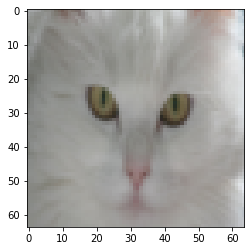

In [16]:
# Example of a picture
index = 50
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [17]:
# Explore the dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


I will reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center>Image to vector conversion. <br> </center></caption>

In [18]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

## 8 - Architecture of  model

Now that we are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

We will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

We will then compare the performance of these models, and also try out different values for $L$. 

Let's look at the two architectures.

### 8.1 - 2-layer neural network

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center>2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Repeat the same process.
- Multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, we take the sigmoid of the result. If it is greater than 0.5, we classify it to be a cat.

### 8.2 - L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, we take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, we take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 8.3 - General methodology

As usual we will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement those two models.

## 9 - Two-layer neural network

Use the helper functions you have implemented previously to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [19]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [20]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Run the cell below to train your parameters. See if your model runs. The cost should be decreasing.

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203885
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.33942815383664127
Cost after iteration 1100: 0.30527536361962654
Cost after iteration 1200: 0.2749137728213015
Cost after iteration 1300: 0.24681768210614854
Cost after iteration 1400: 0.19850735037466102
Cost after iteration 1500: 0.17448318112556652
Cost after iteration 1600: 0.17080762978096745
Cost after iteration 1700: 0.11306524562164724
Cost after iteration 1800: 0.09629426845937154
Cost after iteration 1900: 0.08342617959726865
Cost after iteration 2000: 0.07439078704319083
Cost after iteration 2100: 0.0663074

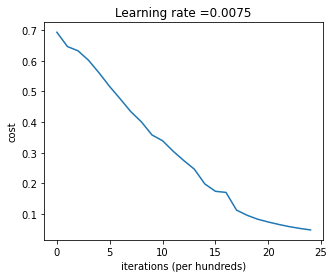

In [21]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

Now, we can use the trained parameters to classify images from the dataset. Predictions on training and test sets:

In [22]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [23]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [24]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


It seems that the 2-layer neural network has a performance of 72%.
Let's see if the $L$-layer model performs better.

## 10 - L-layer Neural Network

Use the helper functions implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [25]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model: 12288 inputs, 3 hidden layers with 20,7,5 hidden units respectively, and an output layer with 1 output unit

In [26]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

We will now train the model as a 4-layer neural network. 

Run the cell below to train the model. The cost should decrease on every iteration.

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


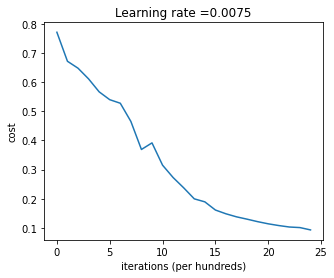

In [27]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Predictions on training and test sets:

In [28]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [29]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


It seems that the 4-layer neural network has better performance (80%) than the 2-layer neural network (72%) on the same test set. 

##  11) Results Analysis

Let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

In [30]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

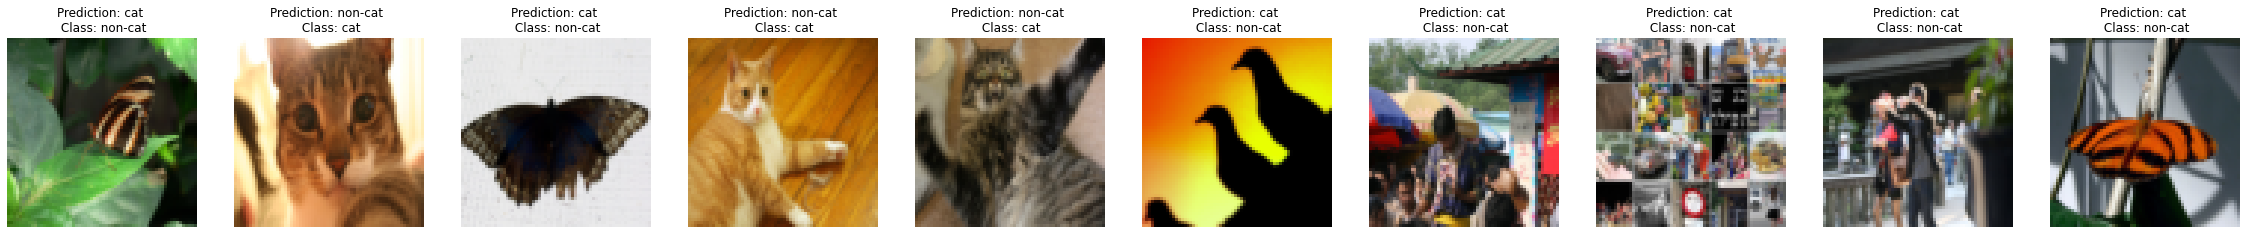

In [31]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

## 7) Test with your own image

In [32]:
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a cat picture.


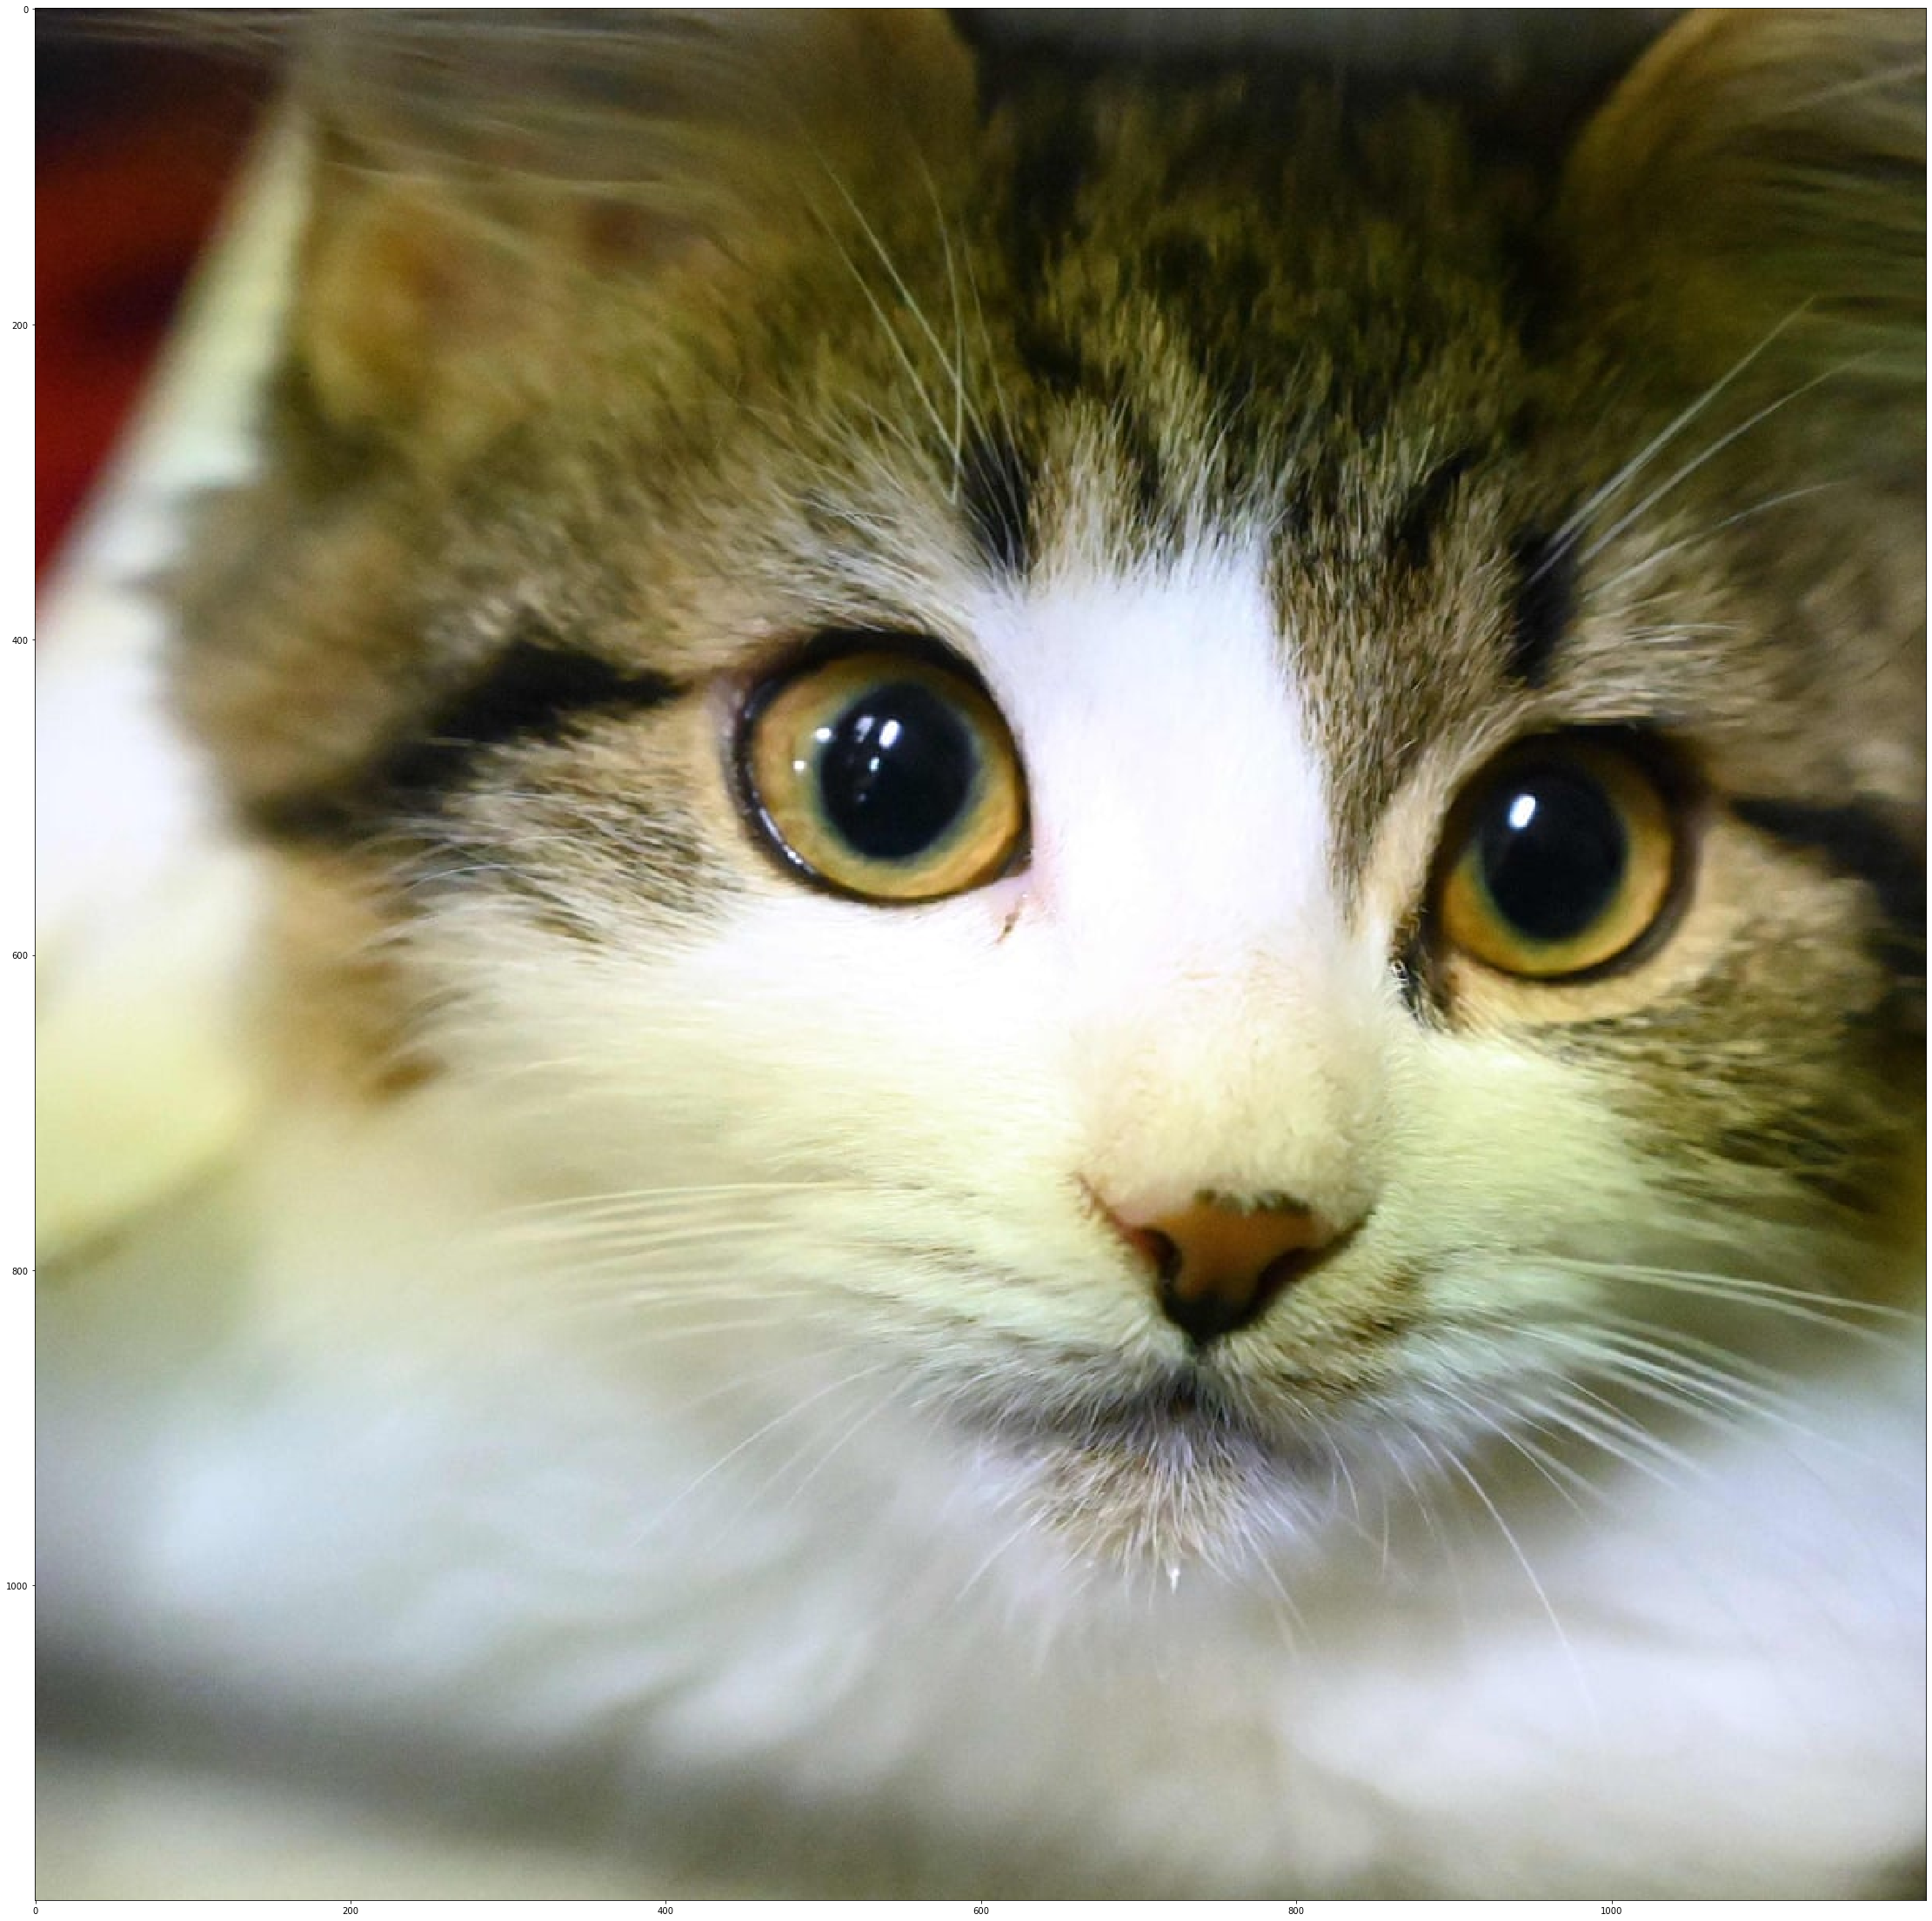

In [33]:
from PIL import ImageOps

my_image = Image.open("my_testset/1.jpg")
size = (num_px,num_px)
image = ImageOps.fit(my_image, size, Image.ANTIALIAS)
image = np.array(image).reshape(num_px*num_px*3,1)
image = image/255.
my_predicted_image = predict(image, my_label_y, parameters)

plt.imshow(my_image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a "\
       + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  \
       " picture.")

Accuracy: 0.0
y = 0.0, your L-layer model predicts a non-cat picture.


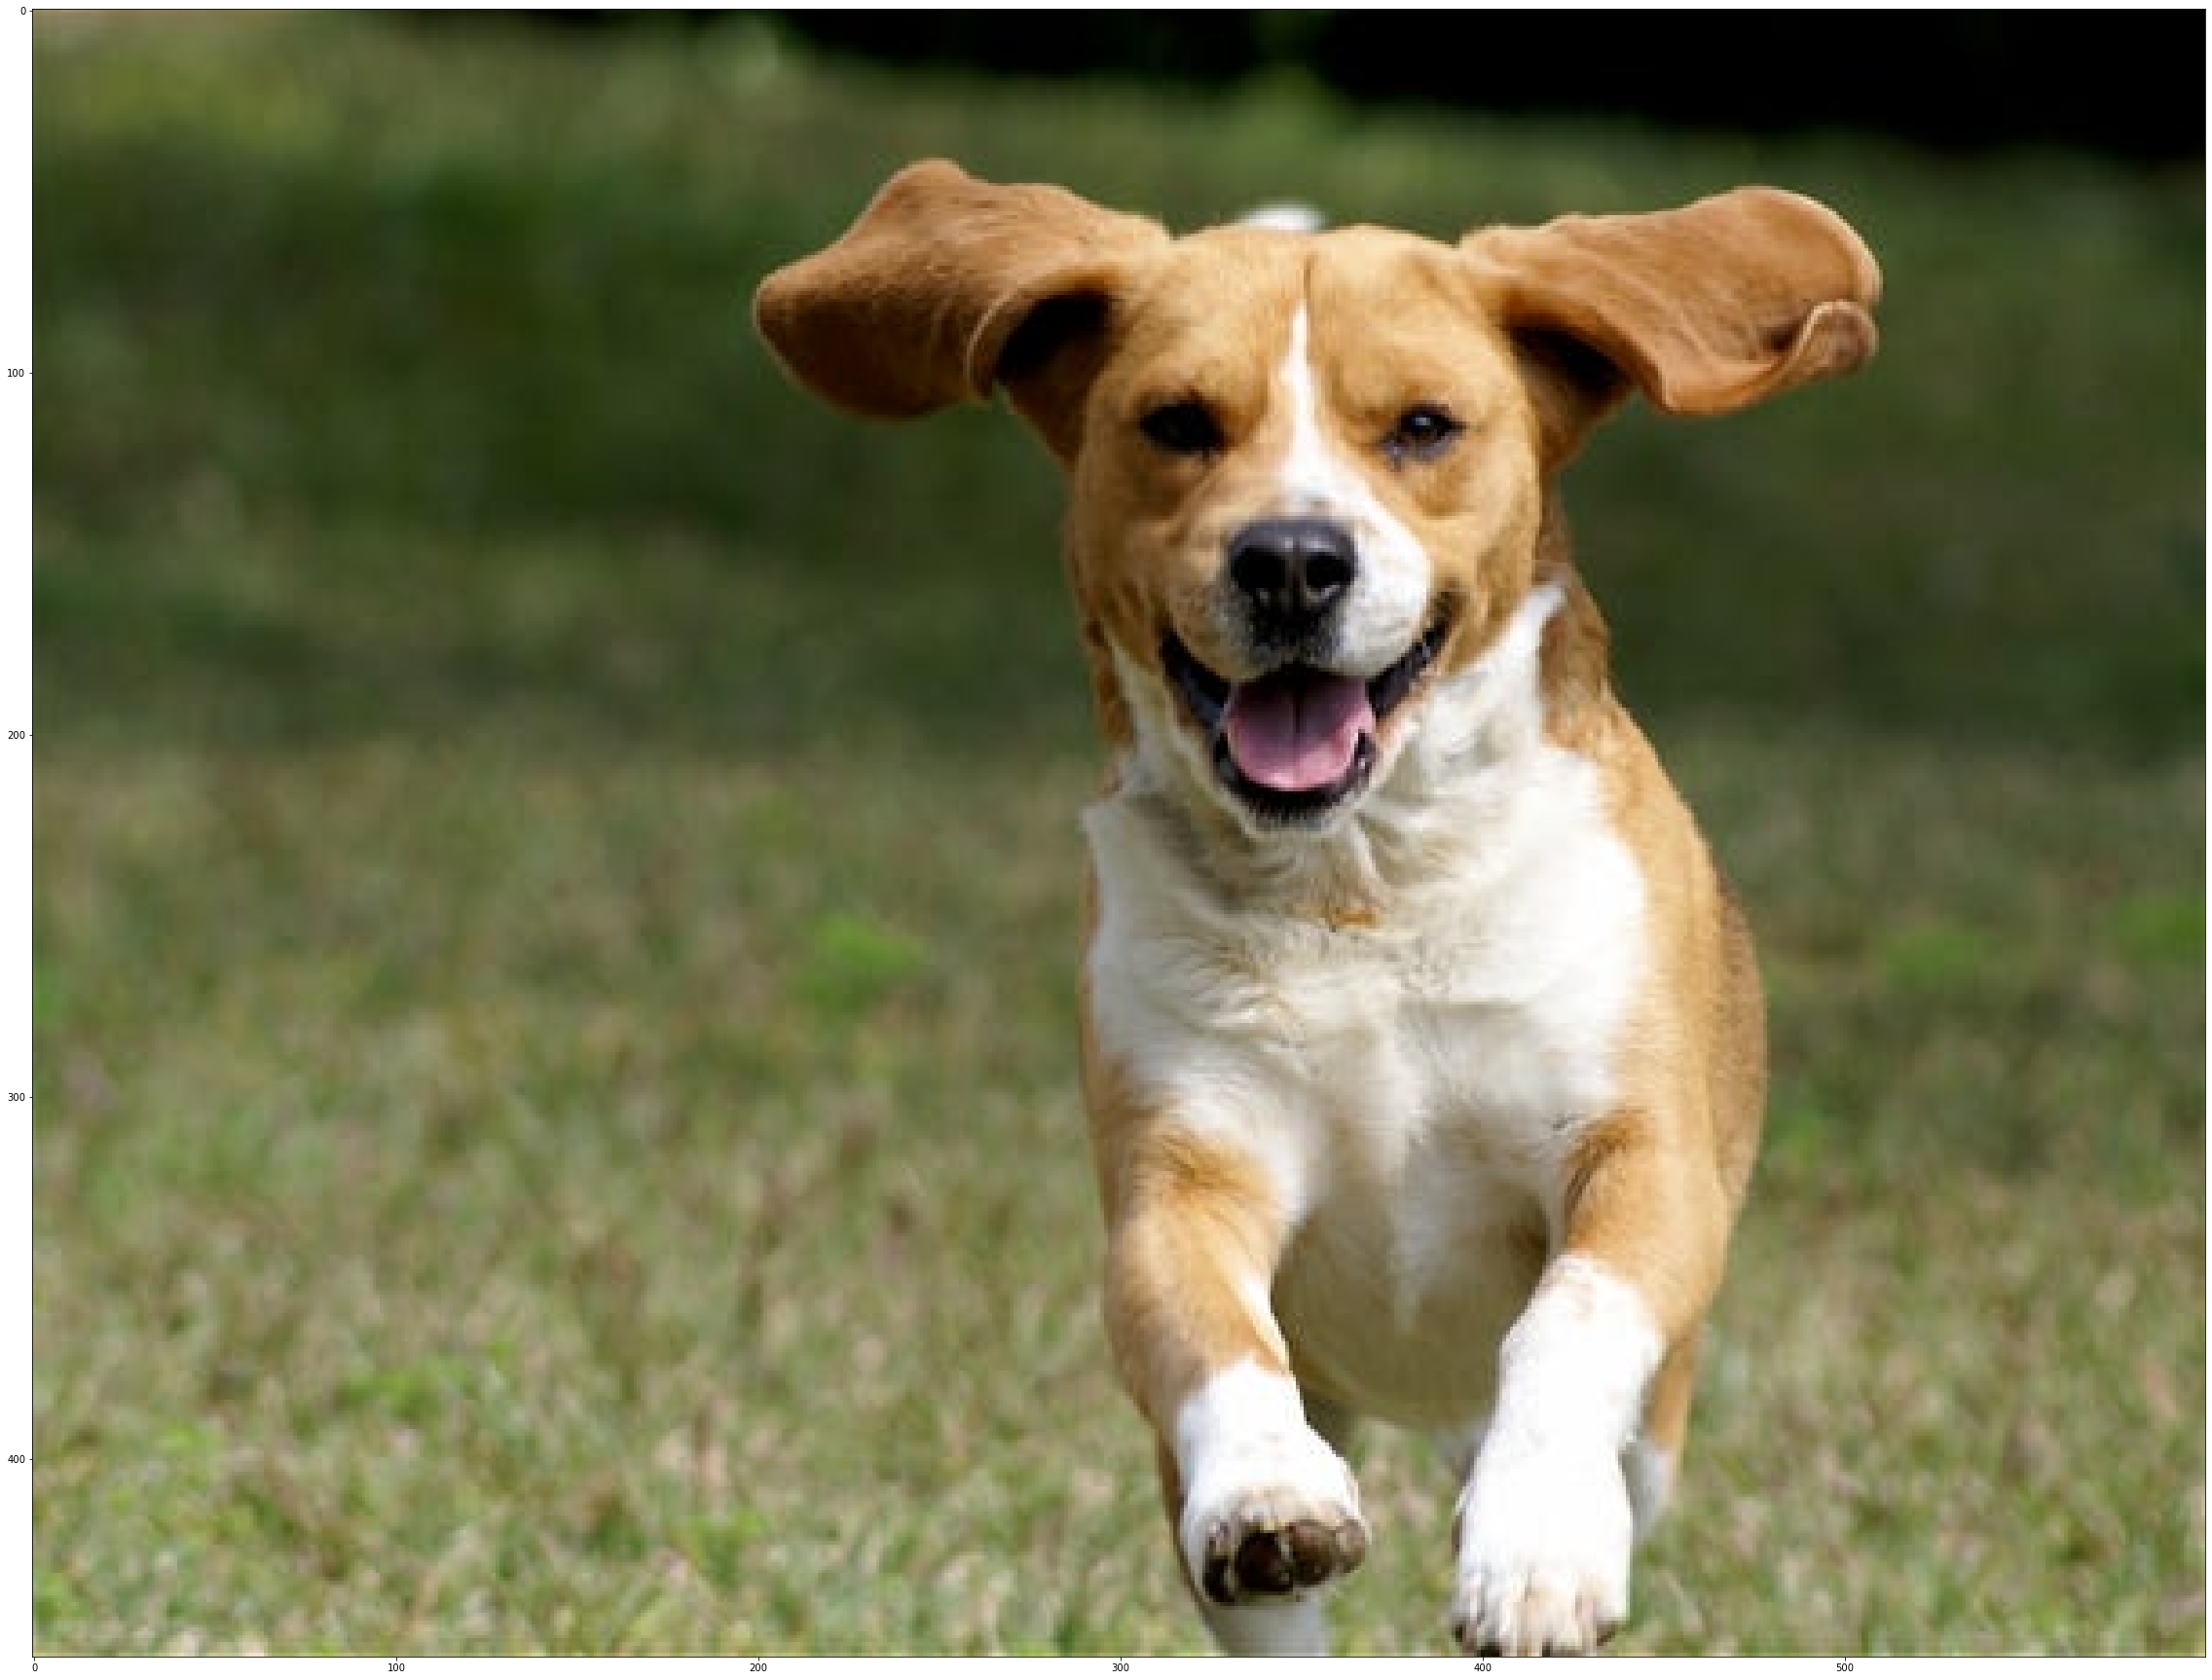

In [34]:
from PIL import ImageOps

my_image = Image.open("my_testset/2.jpg")
size = (num_px,num_px)
image = ImageOps.fit(my_image, size, Image.ANTIALIAS)
image = np.array(image).reshape(num_px*num_px*3,1)
image = image/255.
my_predicted_image = predict(image, my_label_y, parameters)

plt.imshow(my_image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a "\
       + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  \
       " picture.")

# Connect to the Anvil Server

In [35]:
import anvil.server

anvil.server.connect("K6CFKZK4YNSE5SJ6PWSCOJ5E-DD432USGKTOSMAGV")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [36]:
import anvil.media

@anvil.server.callable
def cat_classify(file):
    with anvil.media.TempFile(file) as upload:
        my_image = Image.open(upload)
    
    size = (num_px,num_px)
    image = ImageOps.fit(my_image, size, Image.ANTIALIAS)
    image = np.array(image).reshape(num_px*num_px*3,1)
    image = image/255.
    my_predicted_image = predict(image, my_label_y, parameters)
    
    return (str(np.squeeze(my_predicted_image)), classes[int(np.squeeze(my_predicted_image)),].decode("utf-8"))

Accuracy: 1.0
Accuracy: 0.0
Accuracy: 0.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 0.0
Accuracy: 0.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 0.0
Accuracy: 1.0
Accuracy: 0.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 0.0
Accuracy: 0.0
